# Part 1 - Graph connectivity


In [38]:
%load_ext autoreload
%autoreload 2
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 

from package import constants


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
constants.capacity

1.25

## 1.1 Scripts for generating graphs

In [35]:
# Functions to generate Erdos-Renyi and regular graphs
from networkx import erdos_renyi_graph, random_regular_graph, adjacency_matrix
import networkx as nx

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [198]:
# Generate a graph
n_nodes = 10
graph_er = erdos_renyi_graph(n=n_nodes, p=0.5)
graph_reg = random_regular_graph(d=3, n=n_nodes)

## 1.2 Scripts for checking connectivity

In [210]:
from networkx import adjacency_matrix
from scipy.sparse import identity

def is_irreducible(G: nx.Graph) -> bool:
    adj_mat = adjacency_matrix(G)  # adjacency matrix
    n_nodes = adj_mat.shape[0]     # number of nodes
    taylor_sum = identity(n_nodes) # initialize taylor sum
    add = adj_mat.copy()           # initialize adj_mat^1
    for _ in range(1, n_nodes):
        taylor_sum += add
        add *= adj_mat

    return taylor_sum.min() > 0

In [209]:
print(f'Is the Erdos-Renyi graph irreducible? {is_irreducible(graph_er)}')
print(f'Is the regular graph irreducible? {is_irreducible(graph_reg)}')

Is the Erdos-Renyi graph irreducible? True
Is the regular graph irreducible? True


In [211]:
from networkx import laplacian_matrix
from scipy.sparse.linalg import eigs

def lapplacian_is_connected(G: nx.Graph) -> bool:
    lap_mat = laplacian_matrix(G).asfptype()
    eigvals = eigs(lap_mat, # Laplacian matrix
                   k=2, which='SR', # 2 smallest real eigenvalues
                   return_eigenvectors=False) # only eigenvalues
    # print(f'Is this value close to zero? {sorted(eigvals)[1].real}')
    return np.isclose(sorted(eigvals)[1].real, 0) == False

In [212]:
print(f'Is the Erdos-Renyi graph connected? {lapplacian_is_connected(graph_er)}')
print(f'Is the regular graph connected? {lapplacian_is_connected(graph_reg)}')

Is the Erdos-Renyi graph connected? True
Is the regular graph connected? True


In [213]:
def bfs_is_connected(G: nx.Graph) -> bool:
    root = 0 # start at node 0
    visited = np.zeros(G.number_of_nodes(), dtype=bool) # array to keep track of visited nodes
    queue = [root] # queue to keep track of nodes to visit
    while queue:
        node = queue.pop(0) # pop the first node
        if not visited[node]: # if node has not been visited
            visited[node] = True # mark node as visited
            queue.extend([n for n in G.neighbors(node) if not visited[n]]) # add neighbors to queue
    
    # Is all True?
    return visited.all()

In [214]:
print(f'Is the Erdos-Renyi graph connected? {bfs_is_connected(graph_er)}')
print(f'Is the regular graph connected? {bfs_is_connected(graph_reg)}')

Is the Erdos-Renyi graph connected? True
Is the regular graph connected? True


## 1.3 Complexity analysis

In [263]:
import time

# Function to average execution time
def average_execution_time(func, *args, n=20):
    start = time.time()
    for _ in range(n):
        func(*args)
    end = time.time()
    return (end - start) / n

In [321]:
from tqdm import tqdm
trials = []
node_grid = [10, 20, 30, 40, 50, 60, 70]
for n_nodes in tqdm(node_grid):
    for t in range(20):
        # Recreate random graphs
        graph_er = erdos_renyi_graph(n=n_nodes, p=0.5)
        graph_reg = random_regular_graph(d=3, n=n_nodes)

        # Save results
        trials.append({
            'n_nodes': n_nodes,
            'trial': t,
            'irred_er': average_execution_time(is_irreducible, graph_er),
            'irred_reg': average_execution_time(is_irreducible, graph_reg),
            'lap_er': average_execution_time(lapplacian_is_connected, graph_er),
            'lap_reg': average_execution_time(lapplacian_is_connected, graph_reg),
            'bfs_er': average_execution_time(bfs_is_connected, graph_er),
            'bfs_reg': average_execution_time(bfs_is_connected, graph_reg),
        })

100%|██████████| 7/7 [02:33<00:00, 21.86s/it]


In [279]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")
trials = pd.DataFrame(trials)

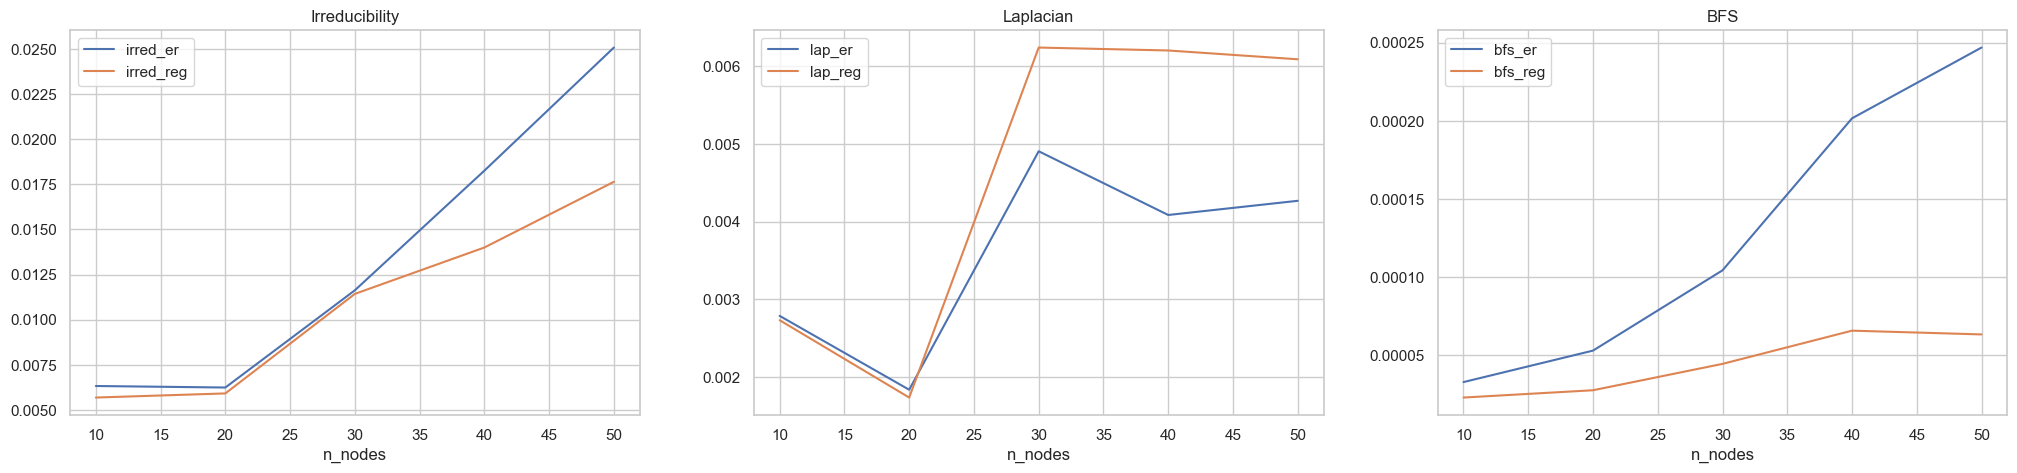

In [280]:
fig, ax = plt.subplots(1, 3, figsize=(25, 5))
trials.groupby('n_nodes').mean().iloc[:, 1:3].plot(ax=ax[0], title='Irreducibility')
trials.groupby('n_nodes').mean().iloc[:, 3:5].plot(ax=ax[1], title='Laplacian')
trials.groupby('n_nodes').mean().iloc[:, 5:7].plot(ax=ax[2], title='BFS')
plt.show()

## 1.4 Probability of connectivity

In [311]:
# Probability of an Erdos-Renyi graph with 100 nodes being connected
n_node = 100
p_grid = np.arange(0, 0.1, 0.0025)
M = 1000 # number of MC simulations
connected_er = np.zeros(len(p_grid))
for i, p in tqdm(enumerate(p_grid), total=len(p_grid)):
    for _ in range(M):
        graph = erdos_renyi_graph(n=n_node, p=p)
        if bfs_is_connected(graph):
            connected_er[i] += 1
connected_er /= M

100%|██████████| 40/40 [01:02<00:00,  1.56s/it]


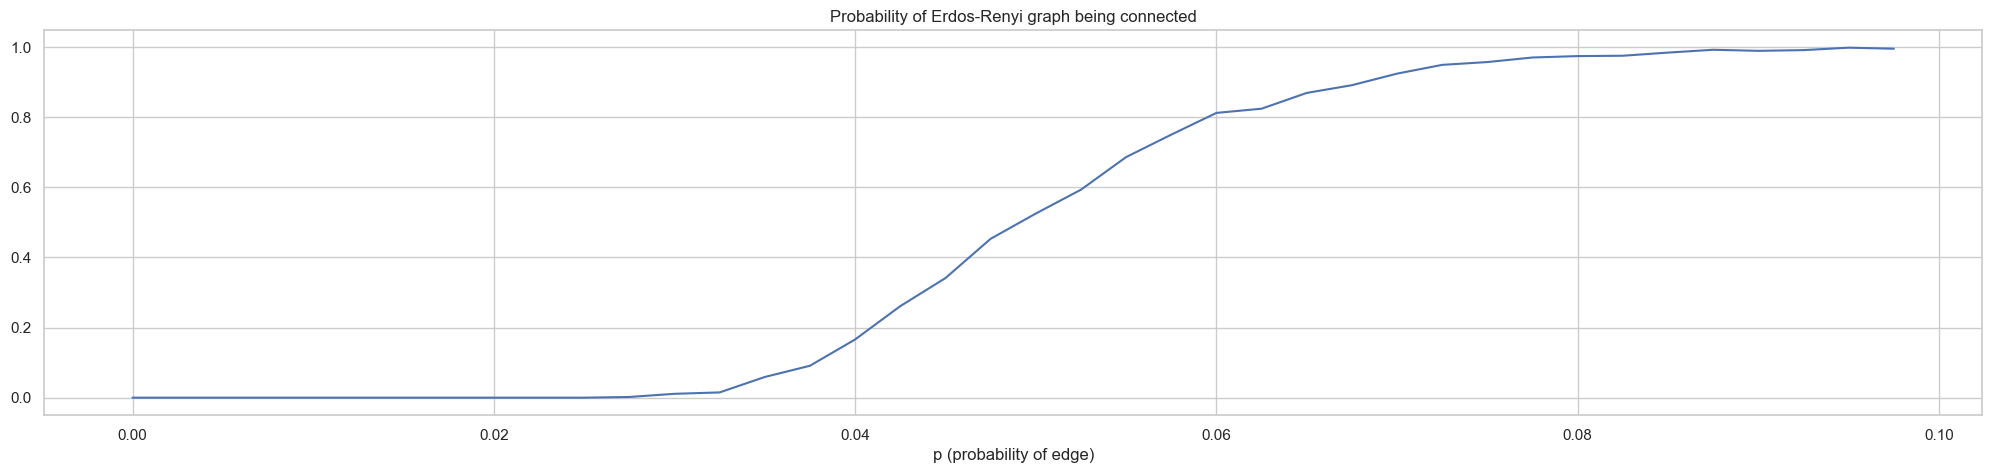

In [312]:
connected_er = pd.Series(connected_er, index=p_grid)
connected_er.plot(title='Probability of Erdos-Renyi graph being connected', figsize=(25, 5))
plt.xlabel('p (probability of edge)')
plt.show()

In [318]:
n_node_grid = np.arange(10, 101, 5)
r1 = 2; r2 = 8;
M = 1000 # number of MC simulations
connected_reg = np.zeros((len(n_node_grid), 2))
for i, n_node in tqdm(enumerate(n_node_grid), total=len(n_node_grid)):
    for _ in range(M):
        graph = random_regular_graph(d=r1, n=n_node)
        if bfs_is_connected(graph):
            connected_reg[i, 0] += 1
        graph = random_regular_graph(d=r2, n=n_node)
        if bfs_is_connected(graph):
            connected_reg[i, 1] += 1
connected_reg /= M

100%|██████████| 19/19 [01:23<00:00,  4.38s/it]


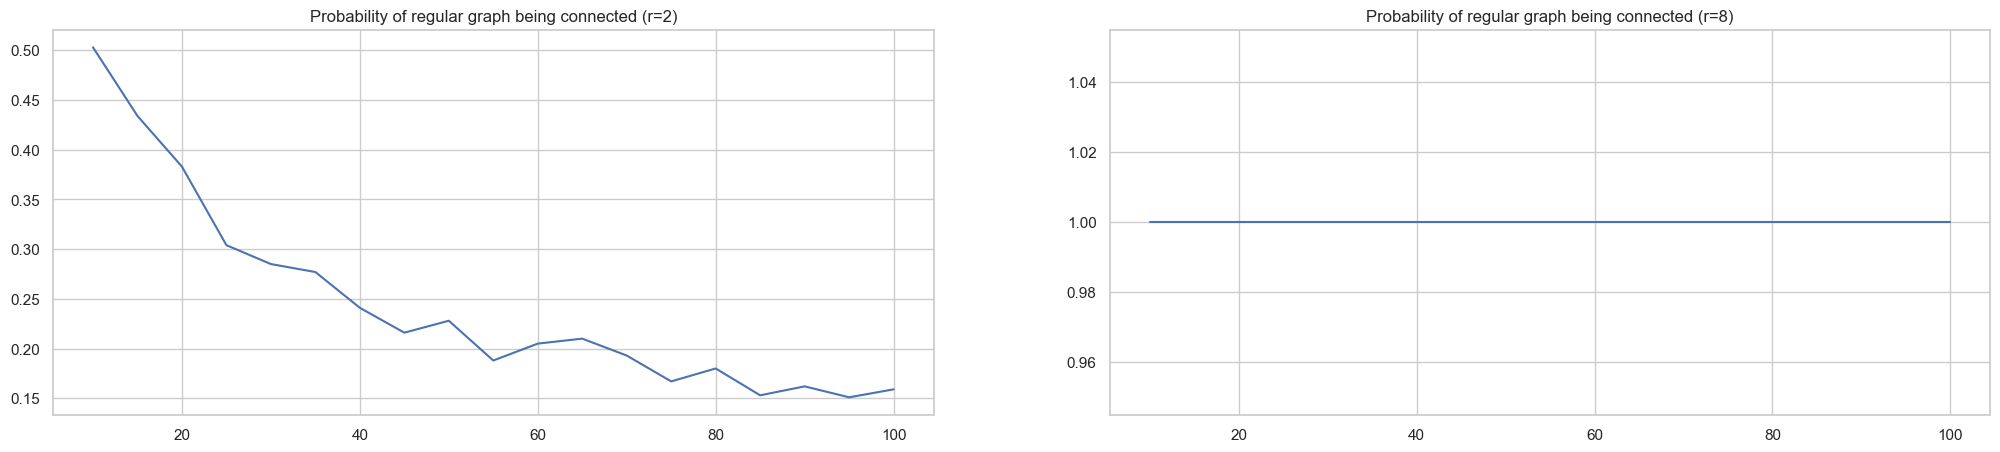

In [319]:
fig, ax = plt.subplots(1, 2, figsize=(25, 5))
connected_reg = pd.DataFrame(connected_reg, index=n_node_grid, columns=[f'r={r1}', f'r={r2}'])
connected_reg['r=2'].plot(ax=ax[0], title='Probability of regular graph being connected (r=2)')
connected_reg['r=8'].plot(ax=ax[1], title='Probability of regular graph being connected (r=8)')
plt.show()